In [1]:
import torch
import torch.nn as nn
import pandas as pd
from chessEngine import ChessEncoder, MLPEngine
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR

# Preprocessing

In [2]:
df = pd.read_csv('data/fen_analysis.csv').sample(frac=1)[:50000] # This shuffles the rows
# df = pd.read_csv('fen_analysis.csv')[:30000] # no shuffle
df

,fen_value,score
63014,2r2B1k/5Q2/6p1/7p/1P2q3/P5P1/B4PKP/8 w - - 1 44,508
244269,rnb1k1nr/1p4q1/2p5/p2p2Bp/8/2PP4/P1PQBPPP/R4RK...,-190
63478,rnbqkbnr/pp1ppppp/8/2p5/4P3/5N2/PPPP1PPP/RNBQK...,-33
260751,Bn2kb1r/p3pppp/2p1qn2/8/8/2N2Q2/PPbPNPPP/R1B1K...,477
89906,r4rk1/1pp2ppp/p3b3/6q1/2n5/PP2P3/1B1P2PP/2R1QR...,3
...,...,...
102088,2R1k3/pp3p1p/4p3/4N3/4Pn2/1P6/6PP/6K1 b - - 1 22,-427
40757,r1bqkb1r/pp1n1ppp/2pppn2/8/3PPP2/3B1N2/PPP3PP/...,124
135165,rnb1kb1r/pp1p1ppp/4p1qn/2p1P3/3P4/2N2N2/PPP2PP...,275
279352,rn3b1r/pppk1Bpp/8/4N3/3PP1n1/8/P1P1KP1P/qN5R b...,705


In [3]:
encoder_object = ChessEncoder()

In [4]:
fen_encodings = []
for fen_i in df['fen_value']:
    encoded_fen = encoder_object.encode_fen(fen_i)
    fen_encodings.append(encoded_fen)

In [5]:
X = torch.tensor(fen_encodings, dtype=torch.int32)

In [6]:
X

tensor([[ 0,  0,  9,  ...,  0, 20, 16],
        [ 9, 11, 10,  ...,  0, 32, 33],
        [ 9, 11, 10,  ...,  0, 39, 39],
        ...,
        [ 9, 11, 10,  ...,  0, 39, 39],
        [ 9, 11,  0,  ...,  0, 20, 33],
        [ 0,  0,  0,  ...,  0,  3, 11]], dtype=torch.int32)

In [7]:
score_encodings = []
for y_i in df['score']:
    # print(y_i)
    encoded_score = encoder_object.encode_score(str(y_i))
    score_encodings.append(encoded_score)
y = torch.tensor(score_encodings, dtype=torch.float32)

In [8]:
X.shape, y.shape

(torch.Size([50000, 200]), torch.Size([50000]))

# Helper Functions

In [9]:
val_split = 10000
test_split = 10000

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
def get_batch(X, Y, bs):
    
    assert isinstance(X, torch.Tensor)
    assert isinstance(Y, torch.Tensor)

    batch = torch.randint(0, len(X), (bs,))
    x = X[batch].to(device)
    y = Y[batch].to(device).to(torch.float32)
    return x, y
# b = get_batch(X, y, 64)

In [12]:
X_val = X[:val_split].to(device)
y_val = y[:val_split].to(device)
X_test = X[val_split:val_split+test_split].to(device)
y_test = y[val_split:val_split+test_split].to(device)
X = X[val_split+test_split:]
y = y[val_split+test_split:]

In [13]:
len(X)

30000

# Training

In [14]:
# hyperparameters
lr = 0.1
num_steps = 500
warmup_steps = 20
bs_train = len(X)
bs_eval = 10000
# allowed_error = 100 #
d1 = {1:10, 2:20}
if bs_train > len(X): bs_train = len(X)

In [15]:
 # i accidenly used a smaller lr for scheduler and it worked better, maybe try it?

In [ ]:
model = MLPEngine(embedding_dim=64, bs_train = bs_train, bs_eval=bs_eval).to(device)
loss_category = nn.MSELoss()
optimiser = torch.optim.AdamW(
            model.parameters(), 
            lr = lr,
            betas=(0.9, 0.999),
            eps=1e-3,
            weight_decay=1e-5)

# Define warm-up and decay
def lr_lambda(epoch):
    if epoch < warmup_steps:  
        return epoch / warmup_steps
    else:  # Exponential decay after warm-up
        return 0.99 ** (epoch - warmup_steps)

scheduler = LambdaLR(optimiser, lr_lambda)
model.compile()

In [17]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True
torch.set_float32_matmul_precision('high')

In [18]:
train_history = {}
val_history = {}
start_step = 0

In [ ]:
model.train()
for step_i in range(1, num_steps+1):
    tot_step = step_i + start_step
    optimiser.zero_grad()
    x_batch, y_batch = get_batch(X, y, bs_train) 
    y_pred = model(x_batch).view(bs_train)
    loss = loss_category(y_pred, y_batch)
    train_history[tot_step] = loss.item()
    loss.backward()
    optimiser.step()
    scheduler.step()
    print(tot_step, ': ',loss.item())

    if tot_step % 100 == 0:
        # validation phase
        model.eval()
        y_pred = model(X_val).view(val_split)
        loss = loss_category(y_pred, y_val)
        val_history[tot_step] = loss.item()
        print(f'Validation at step {tot_step}: {loss.item()}')
        model.train()

start_step += num_steps

1 :  3241063.0
2 :  3297806.75
3 :  3003329.75
4 :  3297276.75
5 :  3084188.0
6 :  3188536.75
7 :  3197020.25
8 :  3113865.25
9 :  3074720.75
10 :  3059351.5
11 :  3131949.0
12 :  3094160.75
13 :  3164653.0
14 :  3209713.0
15 :  3099304.25
16 :  3032793.75
17 :  3038317.75
18 :  2973539.25
19 :  2790335.75
20 :  2929009.25
21 :  2752568.5
22 :  2844289.75
23 :  2809751.75
24 :  2578734.75
25 :  2290647.25
26 :  2269326.75
27 :  2263629.75
28 :  2227348.0
29 :  1884815.125
30 :  1993774.875
31 :  1842455.0
32 :  1668172.625
33 :  1486562.375
34 :  1378233.0
35 :  1183830.625
36 :  1155707.25
37 :  972651.8125
38 :  916899.875
39 :  750574.125
40 :  682953.3125
41 :  624555.6875
42 :  545994.9375
43 :  483493.78125
44 :  369911.0
45 :  407892.6875
46 :  364502.28125
47 :  316427.90625
48 :  288839.75
49 :  284940.8125
50 :  246687.703125
51 :  246807.25
52 :  253784.546875
53 :  226547.796875
54 :  231794.453125
55 :  208154.546875
56 :  184725.953125
57 :  191477.59375
58 :  192912.1093

In [20]:
torch.save(model.state_dict(), 'saves/model.pt')

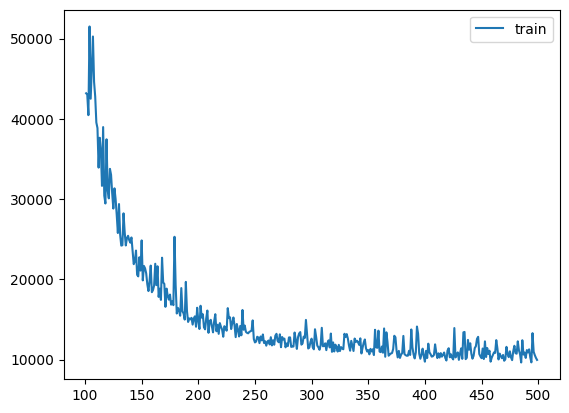

In [21]:
plt.plot(list(train_history.keys())[100:], list(train_history.values())[100:], label='train')
# plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

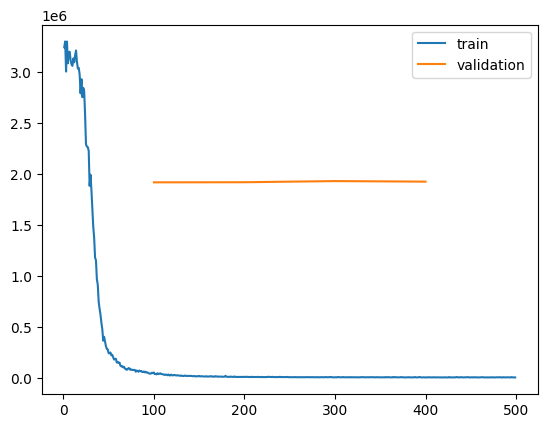

In [22]:
plt.plot(list(train_history.keys()), list(train_history.values()), label='train')
plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

In [23]:
'''
# My results
At relu, model is stuck around 25k with 3x1000 steps with xavier
AT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k
At gelu, model is stuck atound 10k

Adam is better than AdamW for this task
'''

'\n# My results\nAt relu, model is stuck around 25k with 3x1000 steps with xavier\nAT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k\nAt gelu, model is stuck atound 10k\n\nAdam is better than AdamW for this task\n'

# TO DO

- [x] do inference, and run a partially trained model with the GUI intact
- [x] **find a way to fix the fact that our model is giving integer loss
- [x] **Fix the bug in initialisation
- [ ] implement weights and biases or tensorboard 
- [ ] improve the model
  - [x] get a better/ bigger dataset
  - [ ] hyperparameter and architecture
    - [x] better encoding
    - [ ] residual connections
    - [ ] try adamW after tuning b1 and b2
    - [x] increase embedding dim
    - [x] increase neurons in the layers
    - [x] increase layers in the network
    - [x] change loss function (maybe)
    - [ ] try diff learning rate scheduler(trapeziodal)
    - [ ] Add regularisation
      - [ ] l1,l2
      - [x] dropout
    - [x] Better initialisation
    - [x] diff optimisation algorithm

# Note